# Simulation of an Metal Oxide Semiconductor Diode


The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import  ohm_potential, calc_p_density, calc_n_density, calc_recombination


import synumses.one_dimension.solver as solver

# The limit for approximating the Bernoulli function by a polynome is increased!
#parameters.bernoulli_limit = 5E0

## Definition of the geometry of the MOS diode
The band gap of $\mathrm{SiO_x}$ is set to $E_\mathrm{g} = 5.3\,\mathrm{eV}$.<br>
The doping level of the silicon is set to $N_\mathrm{a}=1 \cdot 10^{14}\,\mathrm{cm^3}$.

In [2]:
parameters.n = 200 #300
parameters.lx = 2400E-9 #2400E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24  

Nd_SiO   = 0.0
Na_Si    = 1.0E20

Er_SiO = 4.0
Er_Si = 11.6

Chi_Si  = 4.05
Eg_Si   = 1.12

Chi_SiO = 2.27
Eg_SiO  = 5.2

# Transition SiO to Si
x1 = 10E-9

for i in range(0, parameters.n):
    
    if parameters.pos_x[i] < x1:
        parameters.Chi[i] = Chi_SiO
        parameters.Eg[i]  = Eg_SiO
        
        parameters.Epsilon[i] =  parameters.Epsilon_0 * Er_SiO      
        
        parameters.C[i] = + Nd_SiO
        
    else:
        parameters.Chi[i] = Chi_Si
        parameters.Eg[i]  = Eg_Si
        
        parameters.Epsilon[i] =  parameters.Epsilon_0 * Er_Si
        
        parameters.C[i] = - Na_Si
   

## Plot MOS structure

Now, we plot the default band diagram and the doping levels

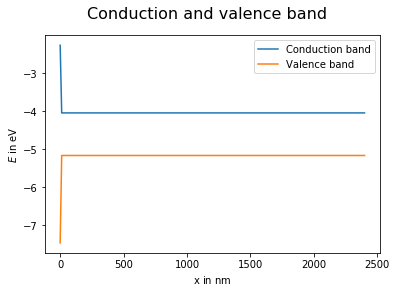

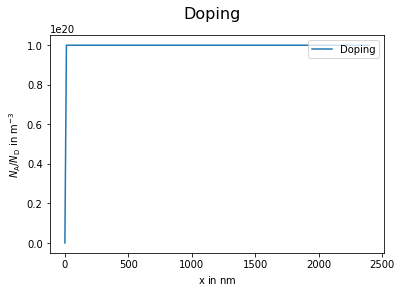

In [3]:
# Band diagram
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.Chi, label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.Chi-parameters.Eg, label='Valence band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

# Doping level
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

#axis.semilogy(np.abs(parameters.C), label='Doping')
axis.plot(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend(loc='upper right')
plt.show()


## Simulaiton without biasing

In [4]:
solver.solve_from_doping()
solver.solve_no_bias()

/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


True

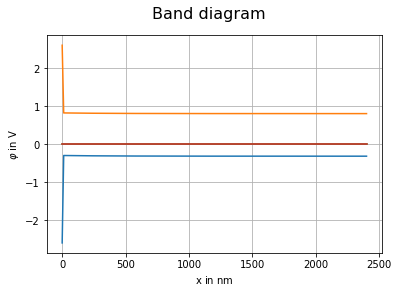

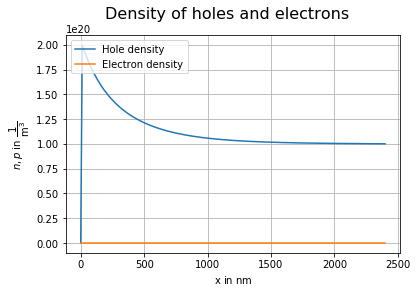

In [5]:
#
# Plot Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

axis.grid()
plt.show()

#
# Plot hole and electron density
#
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

#plt.ylim((0,.4E20))

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n, p$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.grid()
axis.legend(loc='upper left')
plt.show() 

## Perform gate voltage sweep

The seewp is performed between $U_{Start}=0$ and $U_{Stop}=4.0 \,\mathrm{V}$.
The voltage steps are small $\Delta U = 0.05\,\mathrm{V}$. <br>

In [6]:
voltage = []
charge = []

parameters.Cau = np.full(parameters.n, 0) #1E-24

solver.solve_no_bias()

u_actual = 0.0
u_stop    = 4.0
u_step    = 0.05
voltage = []
current_density = []

while (u_actual<=u_stop):

    old_u = parameters.u.copy() # used 
    step_back = 0.0
    while (True):
        print("Voltage:", u_actual + u_step/2**step_back)
        if (solver.solve_bias(u_actual + u_step/2**step_back,0, norm_max=1E-2) == True): # 
            
            u_actual = u_actual + u_step/2**step_back
            break
            
        parameters.u = old_u.copy()
        step_back    = step_back + 1.0
        
        
    
    j = np.mean(hole_current_density() + electron_current_density())
    voltage.append(u_actual)
    n = calc_n_density()
    charge.append(n.sum())
  

Voltage: 0.05
Voltage: 0.1
Voltage: 0.15000000000000002
Voltage: 0.2
Voltage: 0.25
Voltage: 0.3
Voltage: 0.35
Voltage: 0.39999999999999997
Voltage: 0.44999999999999996
Voltage: 0.49999999999999994
Voltage: 0.5499999999999999
Voltage: 0.6
Voltage: 0.65
Voltage: 0.7000000000000001
Voltage: 0.7500000000000001
Voltage: 0.8000000000000002
Voltage: 0.8500000000000002
Voltage: 0.9000000000000002
Voltage: 0.9500000000000003
Voltage: 1.0000000000000002
Voltage: 1.0500000000000003
Voltage: 1.1000000000000003
Voltage: 1.1500000000000004
Voltage: 1.2000000000000004
Voltage: 1.2500000000000004
Voltage: 1.3000000000000005
Voltage: 1.3500000000000005
Voltage: 1.4000000000000006
Voltage: 1.4500000000000006
Voltage: 1.5000000000000007
Voltage: 1.5500000000000007
Voltage: 1.6000000000000008
Voltage: 1.6500000000000008
Voltage: 1.7000000000000008
Voltage: 1.7500000000000009
Voltage: 1.800000000000001
Voltage: 1.850000000000001
Voltage: 1.900000000000001
Voltage: 1.950000000000001
Voltage: 2.0000000000000

## Plot the results

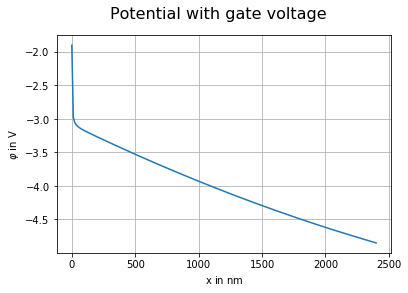

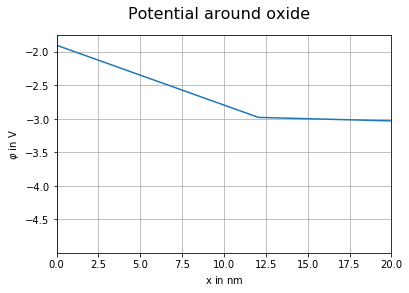

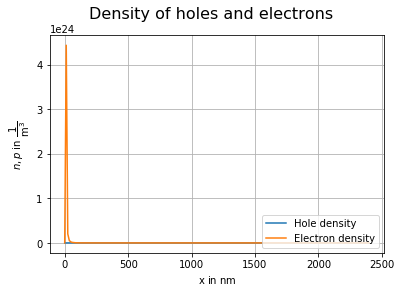

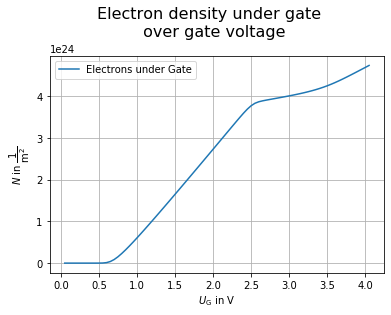

In [7]:
#
# Plot potential
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Potential with gate voltage", fontsize=16)

axis.plot(parameters.pos_x * 1E9, parameters.u[0::3])

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

axis.grid()
plt.show()

#
# Plot potential at the oxide (zoomed)
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Potential around oxide", fontsize=16)

axis.plot(parameters.pos_x * 1E9, parameters.u[0::3])

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

plt.xlim(0,20)

axis.grid()
plt.show()

#
# Hole and electron density
#
calc_p_density()
calc_n_density()

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

#plt.ylim((0,.4E20))

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n, p$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.grid()
axis.legend(loc='lower right')
plt.show() 


#
# Electron density under gate
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Electron density under gate \n over gate voltage", y=1.05,fontsize=16)

axis.plot(voltage, charge ,label='Electrons under Gate')

axis.set_xlabel(r"$U_\mathrm{G}$ in $\mathrm{V}$")
axis.set_ylabel(r"$N$ in $\mathrm{\dfrac{1}{m^2}}$")

axis.grid()
axis.legend(loc='upper left')
plt.savefig("Charge.png")
plt.show() 